## An analysis of SVM models 

By Aniruddh Kishore Budhgavi | iMT2018008 

There's a couple of utility functions get_points and analyze_svm_model which are given here. I want you to focus less on what these functions do internally and more on what their output is. 

In [1]:
import numpy as np 
import pandas as pd 
import sklearn.svm as svm 
import sklearn.metrics as metrics 
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt 

get_points: 

returns a single ndarray with NUM_POINTS rows and 3 columns: x1, x2 and target.
The points are generated such that the points of one class are in a circular pattern, and of the other class are in a "donut" with the given radii. You can choose to have these two being concentric or you can move it around. 

    NUM_POINTS: The number of points to generate.
    ZEROS_FRAC: What fraction of data points should be for class zero? 0 <= ZEROS_FRAC <=1 
    ZEROS_OUTER_RADIUS: >= ZEROS_INNER_RADIUS. The outer radius of the donut. 
    ZEROS_INNER_RADIUS: >= 0. The inner radius of the donut. 
    ONES_RADIUS: >= 0 . The radius of the circle. 
    linearly_separate_data: A boolean. If False, the two classes are concentric. Otherwise, you can shift them around.
    coefficient_of_separation: A float >= 0. How much linear separation is there between the two classes? Value 0: No linear separation. 1: Just about linearly separable. >1 : Fully linearly separable

In [6]:
def get_points(NUM_POINTS, ZEROS_FRAC, ZEROS_OUTER_RADIUS, ZEROS_INNER_RADIUS, ONES_RADIUS, linearly_separate_data=False, coefficient_of_separation=1):
    n_zeros = int(NUM_POINTS*ZEROS_FRAC)
    n_ones = NUM_POINTS - n_zeros
    radii_zeros_init = np.random.uniform(low=ZEROS_INNER_RADIUS, high=ZEROS_OUTER_RADIUS, size=n_zeros)
    theta_zeros_init = np.random.uniform(low=0, high=2*np.pi, size=n_zeros)
    radii_ones_init = np.random.uniform(low = 0, high = ONES_RADIUS, size=n_ones)
    theta_ones_init = np.random.uniform(low=0, high=2*np.pi, size=n_ones)
    x_zeros = radii_zeros_init*np.cos(theta_zeros_init)
    y_zeros = radii_zeros_init*np.sin(theta_zeros_init)
    x_ones = radii_ones_init*np.cos(theta_ones_init)
    y_ones = radii_ones_init*np.sin(theta_ones_init)
    if(linearly_separate_data): 
        separation = coefficient_of_separation*(ZEROS_OUTER_RADIUS+ONES_RADIUS) 
        sep_theta = np.random.uniform(0, 2*np.pi) 
        x_zeros += separation*np.cos(sep_theta)
        y_zeros += separation*np.sin(sep_theta)
    x = np.concatenate([x_zeros, x_ones])
    y = np.concatenate([y_zeros, y_ones])
    to_return = np.zeros((NUM_POINTS, 3))
    to_return[:,0] = x 
    to_return[:,1] = y 
    to_return[:n_zeros,2] = 0 
    to_return[n_zeros:,2] = 1
    to_return[:,0] += np.random.uniform(low=-10,high=10)
    to_return[:,1] += np.random.uniform(low=-10,high=10)
    return to_return

plot_raw_data: Just plots the data in the two classes. Requires a call to plt.show() to tie things together. 

In [7]:
def plot_raw_data(data): 
    zeros = data[data[:,2] == 0,:]
    ones = data[data[:,2] == 1, :]
    plt.scatter(zeros[:,0], zeros[:,1])
    plt.scatter(ones[:,0], ones[:,1])

analyze_svm_model: Trains the given model on the given data with the given number of splits for Stratified K Fold. Displays the F1-score, precision, recall, decision boundary, points correctly and incorrectly classified etc. 

    model: The SVM model you wish to train. 
    N_SPLITS: The number of splits for KFCV 
    data: The training data as defined above. Must be 2D. 

    The decision boundary is computed in the following way: Generate a mesh of points in the space and then find those points in this mesh whose value for the decision function is close to zero. 

    NUM_MESH_POINTS: The number of points in ONE DIMENSION of the mesh. The actual number of mesh points is the square of this, so be careful. 

    MESH_THRESHOLD: For a point x in the mesh, if model.decision_function(x) < MESH_THRESHOLD, we say that x lies on the decision boundary of the model.

In [8]:
def analyze_svm_model(model, N_SPLITS, data, NUM_MESH_POINTS=2000, MESH_THRESHOLD=0.001):
    X = data[:,:2]
    y = data[:,2]
    train_precision_scores = []
    train_recall_scores    = []
    test_precision_scores  = []
    test_recall_scores     = []
    train_f1_scores = []
    test_f1_scores  = []
    kfcv = model_selection.StratifiedKFold(n_splits=N_SPLITS,shuffle=True)
    for train_index, test_index in kfcv.split(X, y): 
        train_X = X[train_index,:]
        test_X  = X[test_index,:]
        train_y = y[train_index]
        test_y  = y[test_index]
        model.fit(train_X, train_y)
        train_yhat = model.predict(train_X)
        test_yhat  = model.predict(test_X) 
        train_precision_scores.append(metrics.precision_score(train_y, train_yhat))
        train_recall_scores.append(metrics.recall_score(train_y, train_yhat))
        train_f1_scores.append(metrics.f1_score(train_y, train_yhat))
        test_precision_scores.append(metrics.precision_score(test_y, test_yhat))
        test_recall_scores.append(metrics.recall_score(test_y, test_yhat))
        test_f1_scores.append(metrics.f1_score(test_y, test_yhat))

    train_f1_scores = np.round(train_f1_scores, 3)
    test_f1_scores  = np.round(test_f1_scores, 3) 
    train_precision_scores = np.round(train_precision_scores, 3) 
    test_precision_scores = np.round(test_precision_scores, 3) 
    train_recall_scores = np.round(train_recall_scores, 3) 
    test_recall_scores = np.round(test_recall_scores, 3)
    yhat_data = data.copy()
    yhat_data[:,2] = model.predict(X)
    print("GROUND TRUTH:")
    plot_raw_data(data)
    plt.show()
    print("PREDICTION:")
    plot_raw_data(yhat_data)
    plt.show()
    difference_data = yhat_data.copy() 
    difference_data[:,2] = data[:,2] != yhat_data[:,2]
    print("MISCLASSIFICATIONS:")
    plot_raw_data(difference_data) 
    plt.show()
    print("DECISION FUNCTION:")
    meshX, meshY = np.meshgrid(np.linspace(np.min(X[:,0]),np.max(X[:,0]),num=NUM_MESH_POINTS),np.linspace(np.min(X[:,1]),np.max(X[:,1]),num=NUM_MESH_POINTS))
    meshXY=np.array([meshX.flatten(),meshY.flatten()]).T
    mesh_decision_function = model.decision_function(meshXY)
    decision_boundary = meshXY[np.abs(mesh_decision_function) < MESH_THRESHOLD]
    plot_raw_data(data)
    plt.scatter(decision_boundary[:,0],decision_boundary[:,1],s=1)
    plt.show()
    print("Train F1 Scores:", train_f1_scores)
    print("\tMean:", np.mean(train_f1_scores))
    print("Test F1 Scores:", test_f1_scores)
    print("\tMean:", np.mean(test_f1_scores))
    print("Train Precision Scores:", train_precision_scores)
    print("\tMean:", np.mean(train_precision_scores))
    print("Test Precision Scores:", test_precision_scores)
    print("\tMean:", np.mean(test_precision_scores))
    print("Train Recall Scores:", train_recall_scores)
    print("\tMean:", np.mean(train_recall_scores)) 
    print("Test Recall Scores:", test_recall_scores)
    print("\tMean:", np.mean(test_recall_scores))




## 1. Warmup: Linearly Separable Data

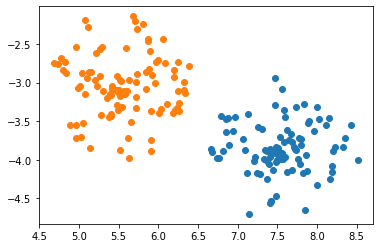

In [11]:
NUM_POINTS = 200
ZEROS_FRAC = 0.5
ZEROS_OUTER_RADIUS = 1
ZEROS_INNER_RADIUS = 0
ONES_RADIUS = 1
linearly_separate_data=True
coefficient_of_separation=1.1
data = get_points(NUM_POINTS, ZEROS_FRAC, ZEROS_OUTER_RADIUS, ZEROS_INNER_RADIUS, ONES_RADIUS, linearly_separate_data=linearly_separate_data, coefficient_of_separation=coefficient_of_separation)
plot_raw_data(data)
plt.show()

GROUND TRUTH:


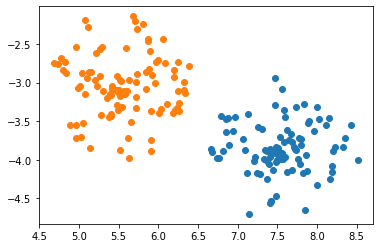

PREDICTION:


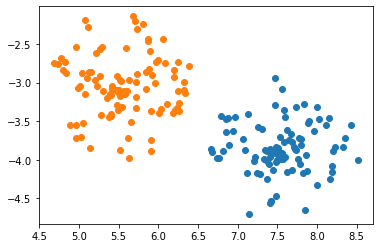

MISCLASSIFICATIONS:


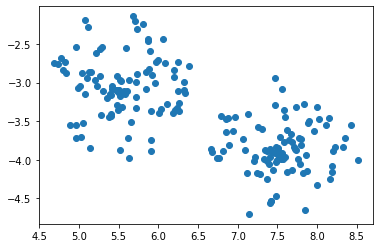

DECISION FUNCTION:


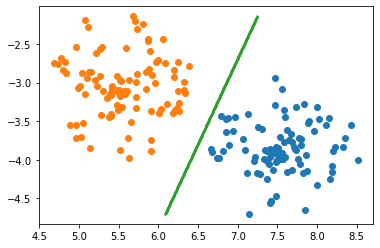

Train F1 Scores: [1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [1. 1. 1. 1. 1.]
	Mean: 1.0
Train Precision Scores: [1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [1. 1. 1. 1. 1.]
	Mean: 1.0


In [12]:
N_SPLITS = 5
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.0025
model = svm.SVC(kernel="linear", C=0.1)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

## 2. Linear data, but not perfectly separable

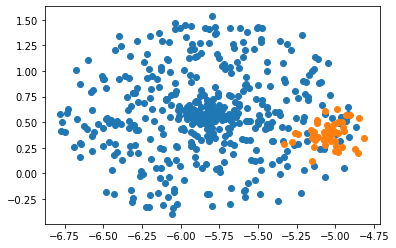

In [13]:
NUM_POINTS = 500
ZEROS_FRAC = 0.9
ZEROS_OUTER_RADIUS = 1
ZEROS_INNER_RADIUS = 0
ONES_RADIUS = 0.3
linearly_separate_data=True
coefficient_of_separation=0.6
data = get_points(NUM_POINTS, ZEROS_FRAC, ZEROS_OUTER_RADIUS, ZEROS_INNER_RADIUS, ONES_RADIUS, linearly_separate_data=linearly_separate_data, coefficient_of_separation=coefficient_of_separation)
plot_raw_data(data)
plt.show()

GROUND TRUTH:


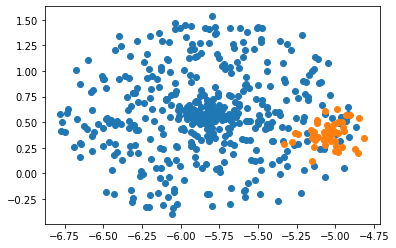

PREDICTION:


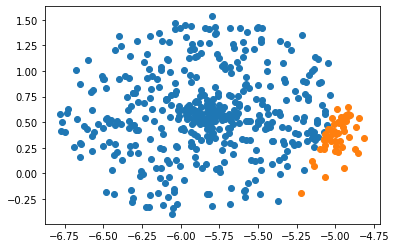

MISCLASSIFICATIONS:


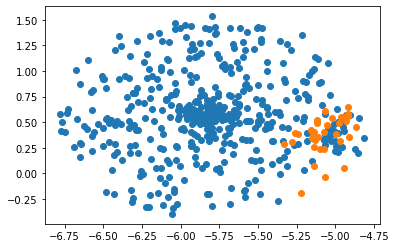

DECISION FUNCTION:


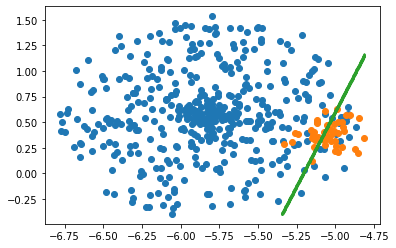

Train F1 Scores: [0.611 0.634 0.738 0.321 0.634]
	Mean: 0.5876
Test F1 Scores: [0.64  0.706 0.692 0.462 0.737]
	Mean: 0.6474000000000001
Train Precision Scores: [0.688 0.619 0.705 0.562 0.619]
	Mean: 0.6386
Test Precision Scores: [0.533 0.857 0.562 1.    0.778]
	Mean: 0.746
Train Recall Scores: [0.55  0.65  0.775 0.225 0.65 ]
	Mean: 0.5700000000000001
Test Recall Scores: [0.8 0.6 0.9 0.3 0.7]
	Mean: 0.6599999999999999


In [14]:
N_SPLITS = 5
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="linear", C=1)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


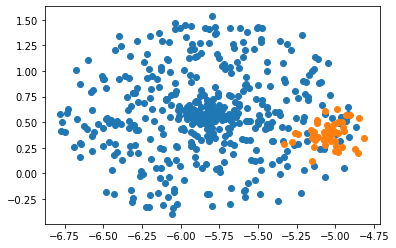

PREDICTION:


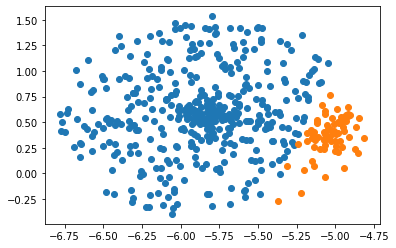

MISCLASSIFICATIONS:


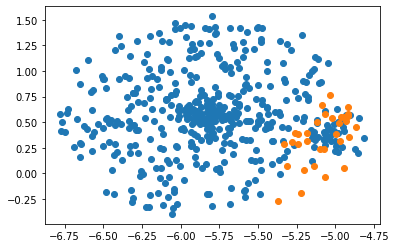

DECISION FUNCTION:


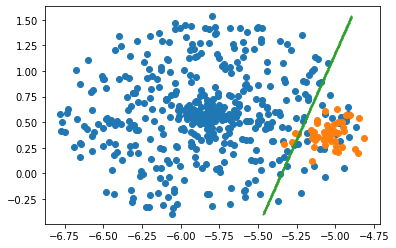

Train F1 Scores: [0.737 0.718 0.757 0.726 0.754 0.726 0.73  0.739 0.75  0.75 ]
	Mean: 0.7387
Test F1 Scores: [0.8   0.889 0.625 0.769 0.615 0.833 0.833 0.714 0.667 0.667]
	Mean: 0.7412
Train Precision Scores: [0.609 0.583 0.636 0.603 0.623 0.603 0.6   0.621 0.627 0.627]
	Mean: 0.6132
Test Precision Scores: [0.8   1.    0.455 0.625 0.5   0.714 0.714 0.556 0.5   0.571]
	Mean: 0.6435
Train Recall Scores: [0.933 0.933 0.933 0.911 0.956 0.911 0.933 0.911 0.933 0.933]
	Mean: 0.9287000000000001
Test Recall Scores: [0.8 0.8 1.  1.  0.8 1.  1.  1.  1.  0.8]
	Mean: 0.9200000000000002


In [16]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.0025
model = svm.SVC(kernel="linear", C=1, class_weight={0:1,1:2.5})
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

## 3. Separable data, but not linearly so.

### 3.1. The RBF Kernel

A very good read: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

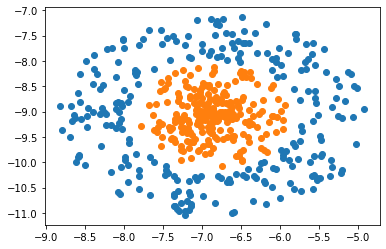

In [17]:
NUM_POINTS = 500
ZEROS_FRAC = 0.5
ZEROS_OUTER_RADIUS = 2
ZEROS_INNER_RADIUS = 1.1
ONES_RADIUS = 1
linearly_separate_data=False
data = get_points(NUM_POINTS, ZEROS_FRAC, ZEROS_OUTER_RADIUS, ZEROS_INNER_RADIUS, ONES_RADIUS, linearly_separate_data=linearly_separate_data)
plot_raw_data(data)
plt.show()

GROUND TRUTH:


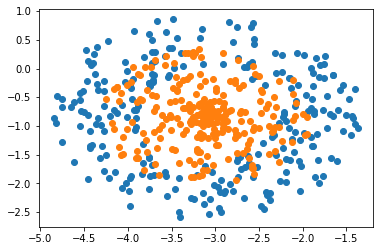

PREDICTION:


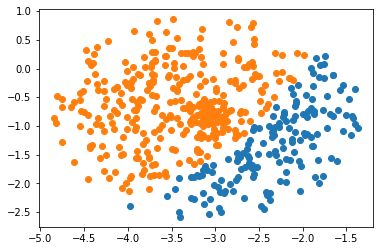

MISCLASSIFICATIONS:


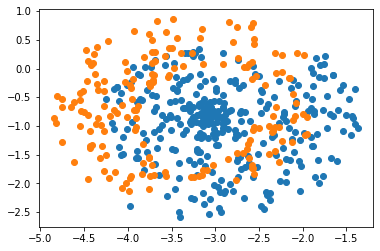

DECISION FUNCTION:


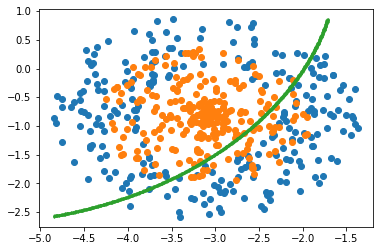

Train F1 Scores: [0.727 0.736 0.709 0.714 0.72  0.715 0.706 0.713 0.714 0.714]
	Mean: 0.7168000000000001
Test F1 Scores: [0.787 0.719 0.698 0.679 0.63  0.712 0.724 0.676 0.677 0.6  ]
	Mean: 0.6901999999999999
Train Precision Scores: [0.602 0.621 0.614 0.597 0.612 0.613 0.592 0.598 0.607 0.619]
	Mean: 0.6075
Test Precision Scores: [0.667 0.59  0.579 0.613 0.586 0.618 0.636 0.535 0.568 0.514]
	Mean: 0.5906
Train Recall Scores: [0.916 0.902 0.84  0.889 0.876 0.858 0.876 0.884 0.867 0.844]
	Mean: 0.8752000000000001
Test Recall Scores: [0.96 0.92 0.88 0.76 0.68 0.84 0.84 0.92 0.84 0.72]
	Mean: 0.8360000000000001


In [31]:
N_SPLITS = 10
NUM_MESH_POINTS = 500
MESH_THRESHOLD = 0.005
model = svm.SVC(kernel="rbf", C=1, gamma=0.01)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


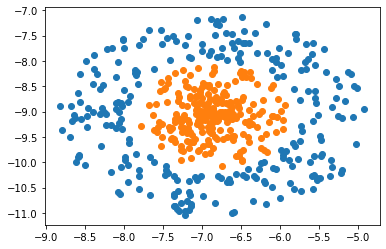

PREDICTION:


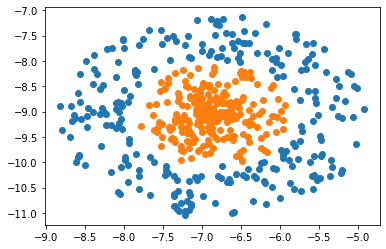

MISCLASSIFICATIONS:


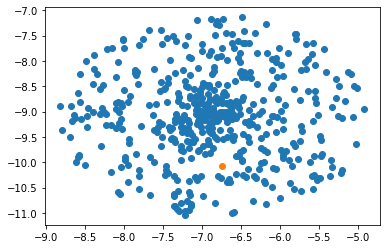

DECISION FUNCTION:


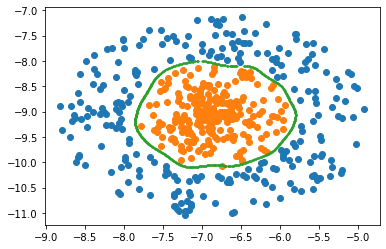

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.98]
	Mean: 0.998
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.96]
	Mean: 0.9960000000000001


In [20]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=1, gamma=10)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


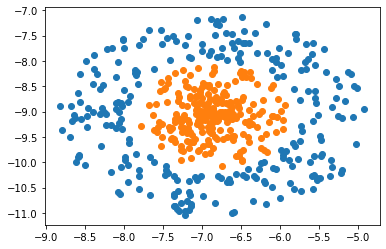

PREDICTION:


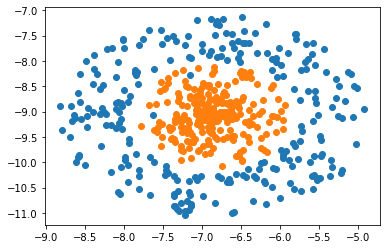

MISCLASSIFICATIONS:


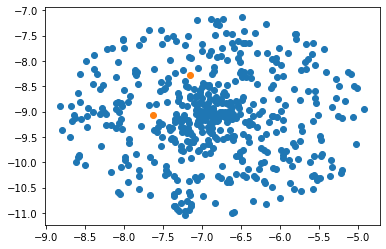

DECISION FUNCTION:


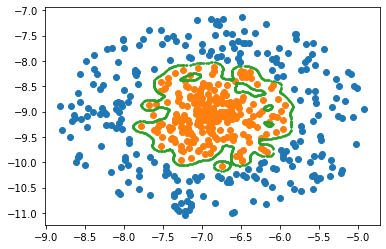

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [0.958 0.98  0.98  1.    0.936 0.98  0.958 0.98  0.98  0.958]
	Mean: 0.9710000000000001
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [0.92 0.96 0.96 1.   0.88 0.96 0.92 0.96 0.96 0.92]
	Mean: 0.944


In [21]:

N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=1, gamma=100)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


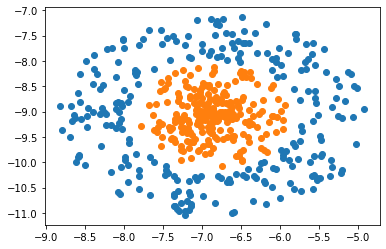

PREDICTION:


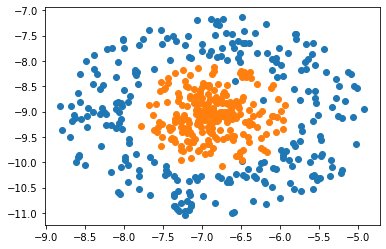

MISCLASSIFICATIONS:


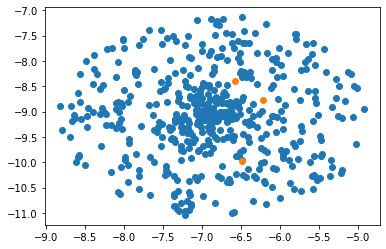

DECISION FUNCTION:


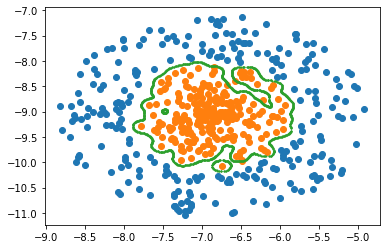

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [0.913 1.    1.    1.    0.98  0.958 0.98  0.958 0.936 0.936]
	Mean: 0.9661
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [0.84 1.   1.   1.   0.96 0.92 0.96 0.92 0.88 0.88]
	Mean: 0.9360000000000002


In [22]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=10, gamma=100)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


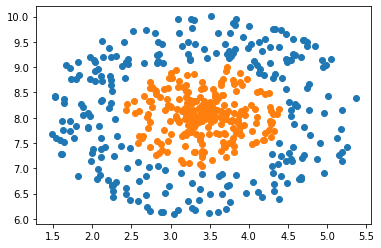

PREDICTION:


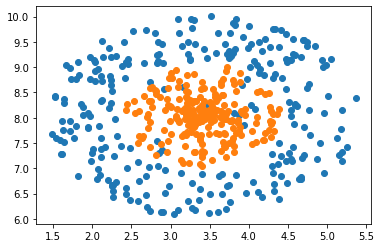

MISCLASSIFICATIONS:


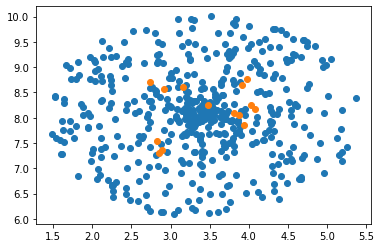

DECISION FUNCTION:


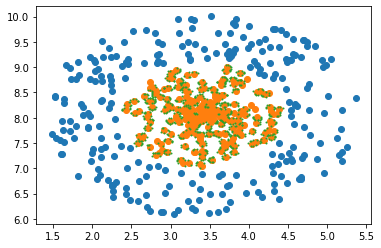

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [0.684 0.529 0.718 0.718 0.78  0.649 0.75  0.75  0.718 0.611]
	Mean: 0.6907
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [0.52 0.36 0.56 0.56 0.64 0.48 0.6  0.6  0.56 0.44]
	Mean: 0.5320000000000001


In [300]:
N_SPLITS = 10
NUM_MESH_POINTS = 500
MESH_THRESHOLD = 0.005
model = svm.SVC(kernel="rbf", C=10, gamma=1000)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


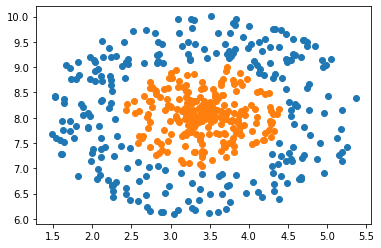

PREDICTION:


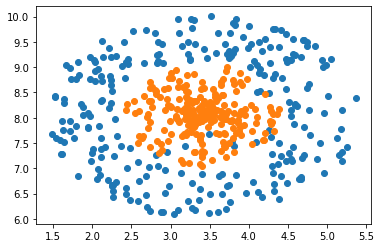

MISCLASSIFICATIONS:


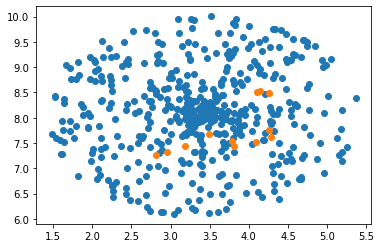

DECISION FUNCTION:


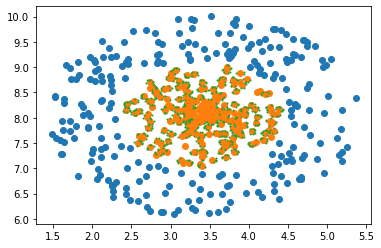

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [0.81  0.611 0.529 0.684 0.649 0.485 0.684 0.611 0.78  0.684]
	Mean: 0.6527000000000001
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [0.68 0.44 0.36 0.52 0.48 0.32 0.52 0.44 0.64 0.52]
	Mean: 0.492


In [301]:
N_SPLITS = 10
NUM_MESH_POINTS = 500
MESH_THRESHOLD = 0.005
model = svm.SVC(kernel="rbf", C=1, gamma=1000)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


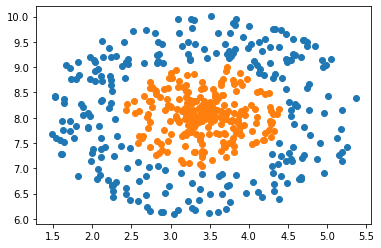

PREDICTION:


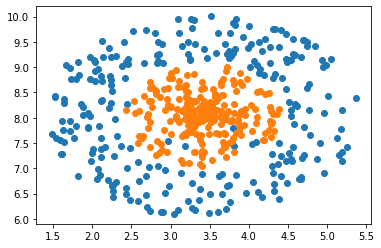

MISCLASSIFICATIONS:


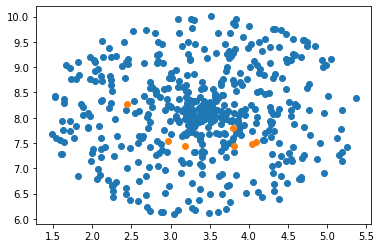

DECISION FUNCTION:


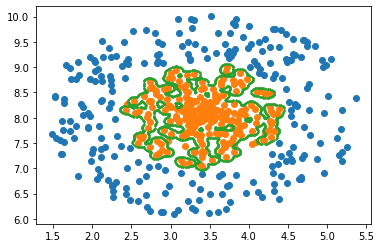

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [0.864 0.81  0.889 0.889 0.81  0.889 0.837 0.81  0.864 0.837]
	Mean: 0.8499000000000001
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [0.76 0.68 0.8  0.8  0.68 0.8  0.72 0.68 0.76 0.72]
	Mean: 0.74


In [309]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=10, gamma=300)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


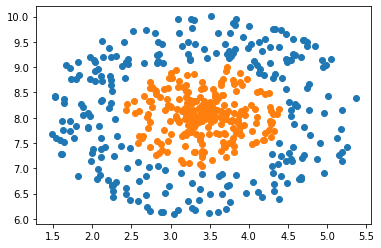

PREDICTION:


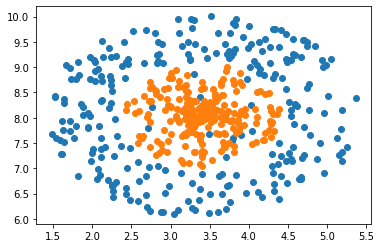

MISCLASSIFICATIONS:


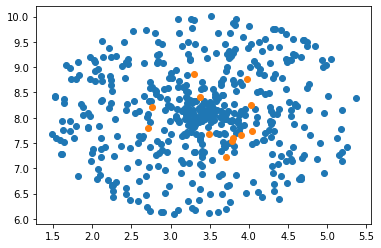

DECISION FUNCTION:


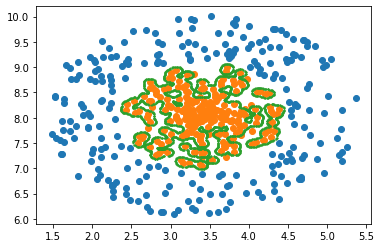

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [0.837 0.78  0.864 0.81  0.958 0.913 0.913 0.837 0.837 0.684]
	Mean: 0.8432999999999999
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [0.72 0.64 0.76 0.68 0.92 0.84 0.84 0.72 0.72 0.52]
	Mean: 0.736


In [310]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=1, gamma=300)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


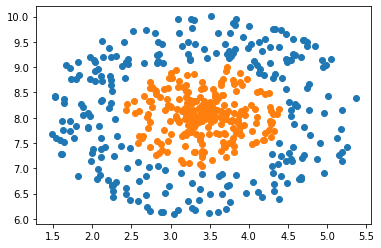

PREDICTION:


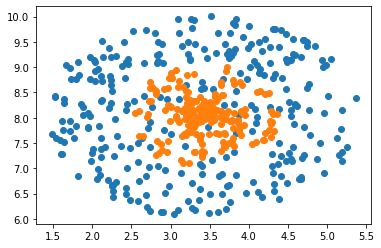

MISCLASSIFICATIONS:


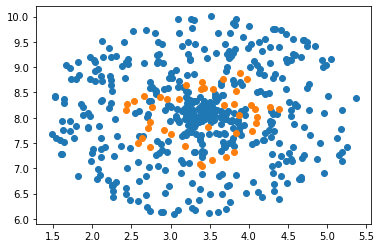

DECISION FUNCTION:


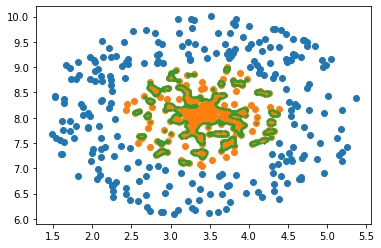

Train F1 Scores: [0.902 0.902 0.886 0.866 0.931 0.946 0.926 0.926 0.946 0.936]
	Mean: 0.9167
Test F1 Scores: [0.571 0.438 0.438 0.438 0.571 0.75  0.571 0.485 0.611 0.571]
	Mean: 0.5443999999999999
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [0.822 0.822 0.796 0.764 0.871 0.898 0.862 0.862 0.898 0.88 ]
	Mean: 0.8474999999999999
Test Recall Scores: [0.4  0.28 0.28 0.28 0.4  0.6  0.4  0.32 0.44 0.4 ]
	Mean: 0.38


In [311]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=0.4, gamma=300)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


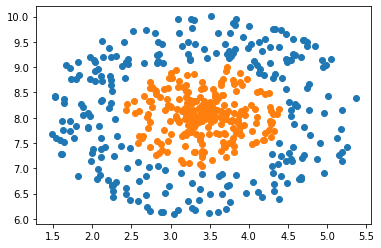

PREDICTION:


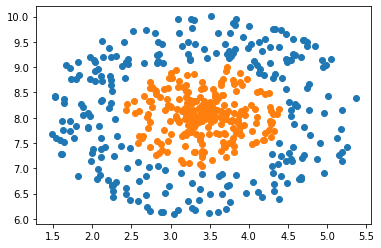

MISCLASSIFICATIONS:


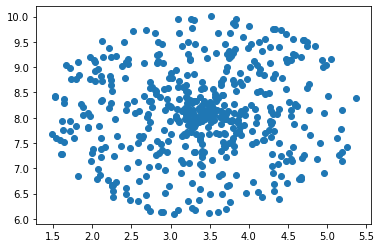

DECISION FUNCTION:


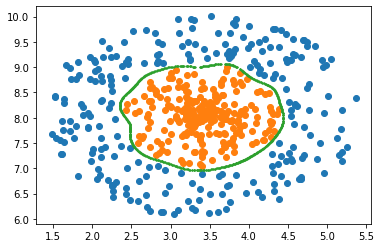

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0


In [312]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=1, gamma=10)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


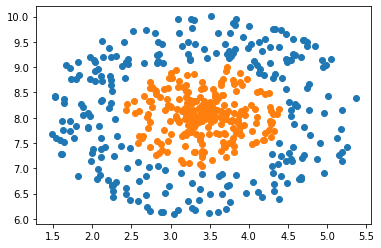

PREDICTION:


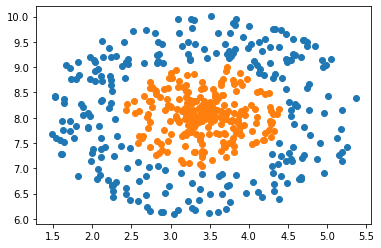

MISCLASSIFICATIONS:


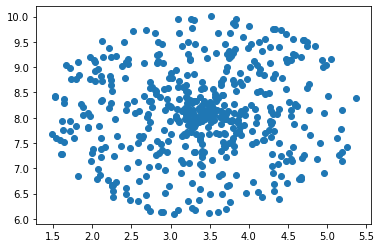

DECISION FUNCTION:


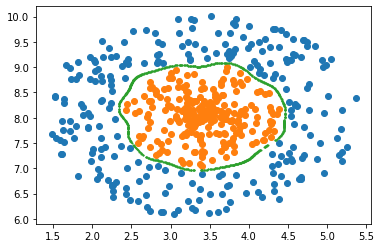

Train F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test F1 Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Precision Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Train Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0
Test Recall Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Mean: 1.0


In [313]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=10, gamma=10)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

## 4. Data that is neither linear nor separable

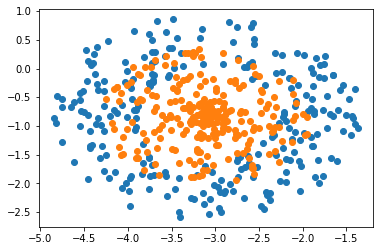

In [24]:
NUM_POINTS = 500
ZEROS_FRAC = 0.5
ZEROS_OUTER_RADIUS = 1.8
ZEROS_INNER_RADIUS = 0.8
ONES_RADIUS = 1.2
linearly_separate_data=False
data = get_points(NUM_POINTS, ZEROS_FRAC, ZEROS_OUTER_RADIUS, ZEROS_INNER_RADIUS, ONES_RADIUS, linearly_separate_data=linearly_separate_data)
plot_raw_data(data)
plt.show()

GROUND TRUTH:


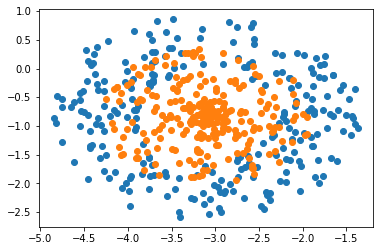

PREDICTION:


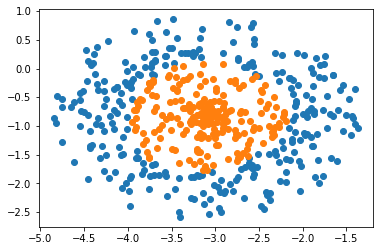

MISCLASSIFICATIONS:


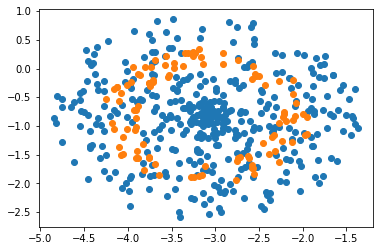

DECISION FUNCTION:


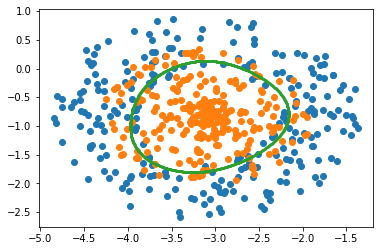

Train F1 Scores: [0.792 0.794 0.793 0.792 0.804 0.809 0.787 0.799 0.798 0.778]
	Mean: 0.7946
Test F1 Scores: [0.769 0.773 0.8   0.84  0.723 0.681 0.826 0.8   0.766 0.8  ]
	Mean: 0.7777999999999999
Train Precision Scores: [0.837 0.83  0.841 0.844 0.847 0.849 0.832 0.842 0.835 0.829]
	Mean: 0.8385999999999999
Test Precision Scores: [0.741 0.895 0.8   0.84  0.773 0.727 0.905 0.8   0.818 0.9  ]
	Mean: 0.8199
Train Recall Scores: [0.751 0.76  0.751 0.747 0.764 0.773 0.747 0.76  0.764 0.733]
	Mean: 0.7550000000000001
Test Recall Scores: [0.8  0.68 0.8  0.84 0.68 0.64 0.76 0.8  0.72 0.72]
	Mean: 0.744


In [25]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=1, gamma=1)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


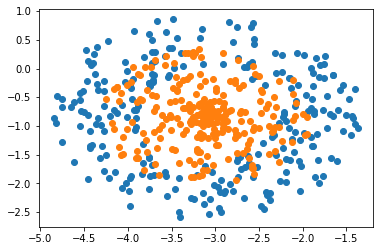

PREDICTION:


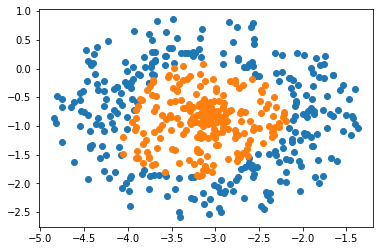

MISCLASSIFICATIONS:


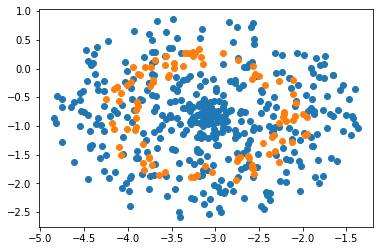

DECISION FUNCTION:


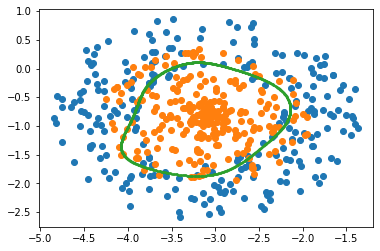

Train F1 Scores: [0.804 0.81  0.789 0.795 0.797 0.782 0.817 0.824 0.815 0.808]
	Mean: 0.8041
Test F1 Scores: [0.727 0.638 0.844 0.875 0.744 0.917 0.735 0.816 0.776 0.72 ]
	Mean: 0.7791999999999999
Train Precision Scores: [0.859 0.872 0.855 0.856 0.861 0.849 0.84  0.86  0.873 0.856]
	Mean: 0.8581000000000001
Test Precision Scores: [0.842 0.682 0.95  0.913 0.889 0.957 0.75  0.833 0.792 0.72 ]
	Mean: 0.8328000000000001
Train Recall Scores: [0.756 0.756 0.733 0.742 0.742 0.724 0.796 0.791 0.764 0.764]
	Mean: 0.7568
Test Recall Scores: [0.64 0.6  0.76 0.84 0.64 0.88 0.72 0.8  0.76 0.72]
	Mean: 0.736


In [26]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=10, gamma=1)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


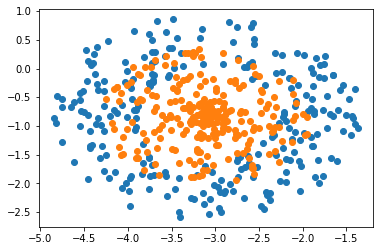

PREDICTION:


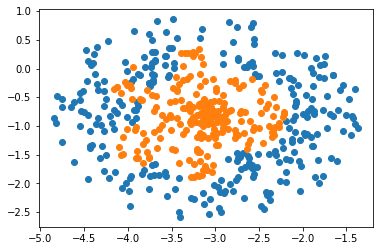

MISCLASSIFICATIONS:


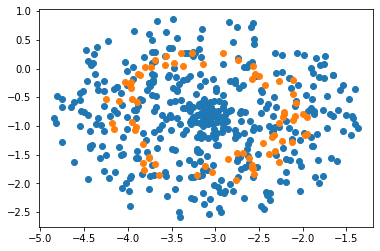

DECISION FUNCTION:


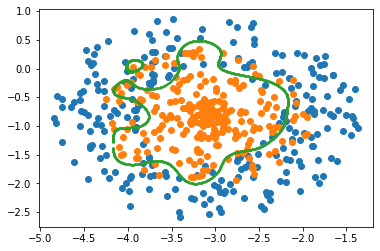

Train F1 Scores: [0.855 0.856 0.863 0.86  0.875 0.874 0.872 0.868 0.864 0.848]
	Mean: 0.8634999999999999
Test F1 Scores: [0.868 0.791 0.792 0.857 0.75  0.833 0.8   0.833 0.84  0.84 ]
	Mean: 0.8204
Train Precision Scores: [0.889 0.927 0.92  0.906 0.913 0.901 0.913 0.908 0.895 0.892]
	Mean: 0.9064
Test Precision Scores: [0.821 0.944 0.826 0.875 0.783 0.87  0.9   0.87  0.84  0.84 ]
	Mean: 0.8569000000000001
Train Recall Scores: [0.822 0.796 0.813 0.818 0.84  0.849 0.836 0.831 0.836 0.809]
	Mean: 0.825
Test Recall Scores: [0.92 0.68 0.76 0.84 0.72 0.8  0.72 0.8  0.84 0.84]
	Mean: 0.792


In [27]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=1, gamma=10)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


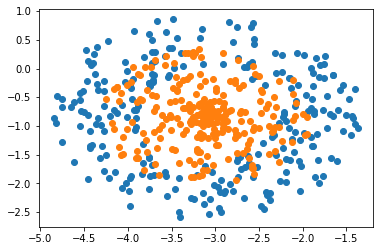

PREDICTION:


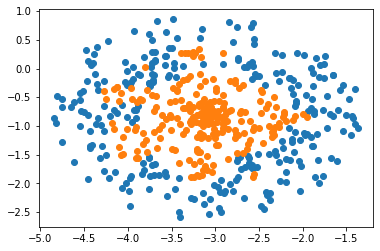

MISCLASSIFICATIONS:


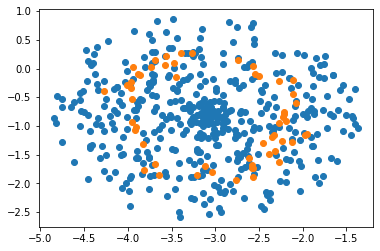

DECISION FUNCTION:


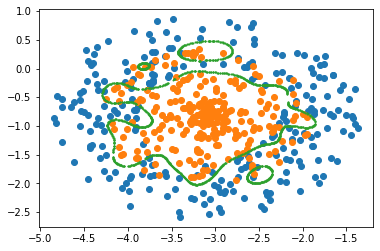

Train F1 Scores: [0.907 0.917 0.894 0.908 0.907 0.904 0.901 0.897 0.901 0.902]
	Mean: 0.9038
Test F1 Scores: [0.784 0.745 0.844 0.755 0.821 0.744 0.815 0.818 0.846 0.75 ]
	Mean: 0.7922
Train Precision Scores: [0.926 0.948 0.928 0.918 0.9   0.91  0.895 0.905 0.895 0.929]
	Mean: 0.9154
Test Precision Scores: [0.769 0.731 0.95  0.714 0.742 0.889 0.759 0.947 0.815 0.783]
	Mean: 0.8098999999999998
Train Recall Scores: [0.889 0.889 0.862 0.898 0.916 0.898 0.907 0.889 0.907 0.876]
	Mean: 0.8930999999999999
Test Recall Scores: [0.8  0.76 0.76 0.8  0.92 0.64 0.88 0.72 0.88 0.72]
	Mean: 0.788


In [28]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=10, gamma=10)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)

GROUND TRUTH:


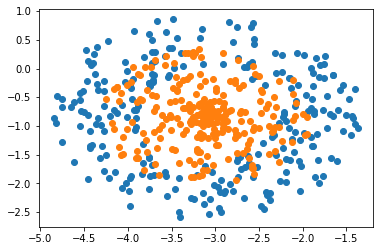

PREDICTION:


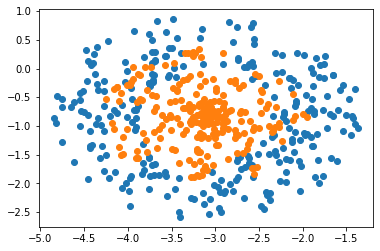

MISCLASSIFICATIONS:


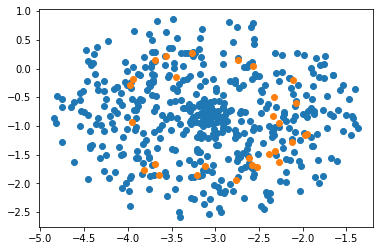

DECISION FUNCTION:


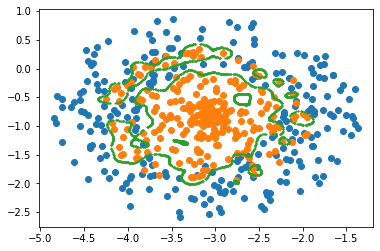

Train F1 Scores: [0.954 0.954 0.952 0.957 0.957 0.957 0.961 0.952 0.959 0.957]
	Mean: 0.9560000000000001
Test F1 Scores: [0.87  0.809 0.694 0.857 0.816 0.762 0.75  0.894 0.826 0.792]
	Mean: 0.807
Train Precision Scores: [0.986 0.981 0.981 0.977 0.986 0.986 0.986 0.981 0.977 0.986]
	Mean: 0.9827
Test Precision Scores: [0.952 0.864 0.708 0.875 0.833 0.941 0.783 0.955 0.905 0.826]
	Mean: 0.8642
Train Recall Scores: [0.924 0.929 0.924 0.938 0.929 0.929 0.938 0.924 0.942 0.929]
	Mean: 0.9306000000000001
Test Recall Scores: [0.8  0.76 0.68 0.84 0.8  0.64 0.72 0.84 0.76 0.76]
	Mean: 0.76


In [29]:
N_SPLITS = 10
NUM_MESH_POINTS = 1000
MESH_THRESHOLD = 0.01
model = svm.SVC(kernel="rbf", C=1, gamma=100)
analyze_svm_model(model, N_SPLITS,data, NUM_MESH_POINTS=NUM_MESH_POINTS,MESH_THRESHOLD=MESH_THRESHOLD)